# Compute rotary spectra on mitgcm outputs (SSU and SSV)



---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
from cmocean import cm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.112:8786 Dashboard: http://10.148.0.112:8787/status,Cluster Workers: 10 Cores: 140 Memory: 1000.00 GB


---

# All faces

## compute and store spectra for all faces

In [6]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

v_u = 'SSU'
v_v = 'SSV'

## open files, nc files (SSU,SSV) ##
ncdata_dir = '/home1/scratch/xyu/mit_nc/'

# dir where spectra are stored
E_dir = '/home1/scratch/xyu/mit_spec/'

print(ncdata_dir)
print(E_dir)


# number of fies to load for each face (1 file = 10 days)
Nf = 5

mgrid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])


/home1/scratch/xyu/mit_nc/
/home1/scratch/xyu/mit_spec/


In [7]:
## Here we do DFT on u+iv ##

for face in range(0,13):
    
    # SSU #
    filenames_u = sorted(glob(ncdata_dir+v_u+'_f%02d_t*.nc' %(face)))
    filenames_u = filenames_u[:Nf]
    # SSV #
    filenames_v = sorted(glob(ncdata_dir+v_v+'_f%02d_t*.nc' %(face)))
    filenames_v = filenames_v[:Nf]    
    # Grid #
    grid = mgrid.isel(face=face)
    
    # Read SSU #
    ds = xr.open_mfdataset(filenames_u, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    chunks={'time': len(ds['time'])}
    ds = ds.chunk(chunks)    

    # Read SSV #
    ds_v = xr.open_mfdataset(filenames_v, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    chunks_v={'time': len(ds_v['time'])}
    ds_v = ds_v.chunk(chunks_v)
    
    # Merge into one xarray dataset #
    ds = xr.merge([ds_v,ds])
    
    # u+iv #
    uv_complex = (ds[v_u] + 1j*ds[v_v])
    # DFT on u+iv #
    uv_fft = xrft.dft(uv_complex.fillna(0.), dim=['time'], shift=False, detrend='linear')
    E_uv = (uv_fft*uv_fft.conj()).where(uv_fft!=0., drop=False) #.mean(dim=('i','j'))
    E_uv = E_uv.astype('f8').rename('E')
    # Merge into one xarray dataset #
    E_uv = xr.merge([E_uv, grid])
    
    # chunksizes = [432, 432, 1]

    # Write NetCDF files#
    file_E = E_dir+'E_uv_f%02d.nc'%face    
    %time E_uv.to_netcdf(file_E, mode='w') #, encoding={'E_uv': {'chunksizes': chunksizes}})
    
    print('face %d done'%face )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 9.47 MB detected in task graph: 
  ("('astype-cb3ac6b6169d7c70782f86a52c844b1d', 0, 0 ... f978>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


CPU times: user 24min 36s, sys: 1min 30s, total: 26min 7s
Wall time: 1h 4min 10s
face 12 done


______
## zonally average spectra

Faces are processed independantly, this alleviate the computational burden on the scheduler (large task graph issue)


In [8]:
face = 12

file_E = E_dir+'E_uv_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})
print(ds)
print('\n data size: %.1f GB' %(ds['E'].nbytes / 1e9))


<xarray.Dataset>
Dimensions:            (freq_time: 1200, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 2.315e-07 4.63e-07 6.944e-07 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 2160)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 2160)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 2160)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 2160)>
Data variables:
    E                  (i, j, freq_time) float64 dask.array<shape=(4320, 4320, 1200), chunksize=(1, 2160, 1200)>

 data size: 179.2 GB


In [7]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
for face in range(0,13):

    file_E = E_dir+'E_uv_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')
    ds_zavg.to_netcdf(E_dir+'E_rotary_zavg_f%02d.nc'%face, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


## load and plot zonally averaged spectra

In [11]:
filenames = sorted(glob(E_dir+'E_uv_zavg_f*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')
print(ds)

CPU times: user 52 ms, sys: 20 ms, total: 72 ms
Wall time: 715 ms
<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 479, lat: 120)
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001386 -0.000138 -0.0001374 ...
Dimensions without coordinates: face
Data variables:
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 479), chunksize=(1, 120, 479)>
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>


In [8]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
print(E)

<xarray.DataArray (lat: 120, freq_time: 479)>
dask.array<shape=(120, 479), dtype=float64, chunksize=(120, 479)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001386 -0.000138 -0.0001374 ...


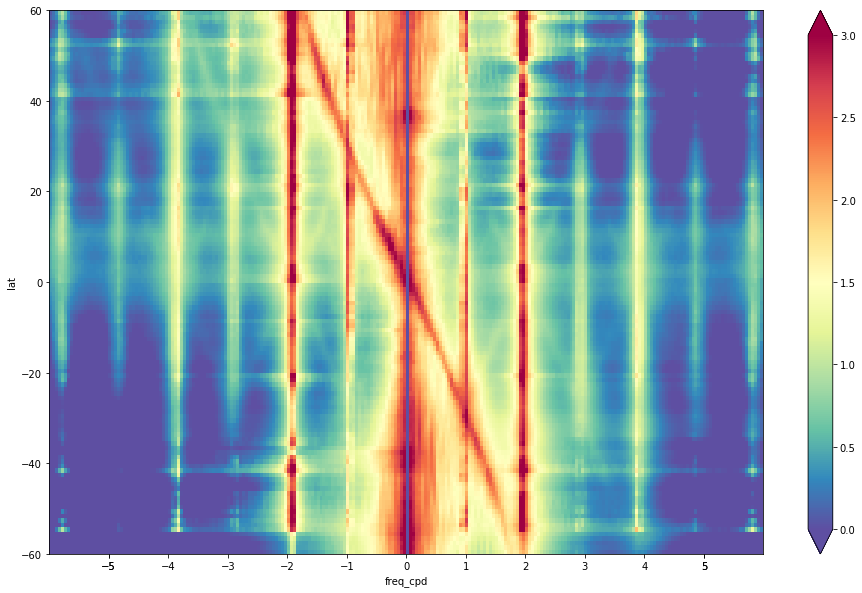

In [12]:
# Figure #
plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
np.log10(E).plot.pcolormesh(ax=ax, vmin=-0., vmax=3., x='freq_cpd', y='lat', cmap = 'Spectral_r')

ax.set_xticks(list(ax.get_xticks()) + [-5., -4., -3., -2., -1., 1., 2., 3., 4., 5.])
ax.set_xlim(-12., 12.)
ax.set_xlim(-6., 6.)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
#ax.plot(f*86400./2./np.pi,f.lat,'w--')
#ax.plot(-f*86400./2./np.pi,f.lat,'w--')
plt.savefig('Rotary_spectra_20days.png')

---

In [8]:
client.restart()

Client Scheduler: tcp://10.148.0.112:8786 Dashboard: http://10.148.0.112:8787/status,Cluster Workers: 10 Cores: 140 Memory: 1000.00 GB
